# Import and Install Dependencies

In [1]:
pip install opencv-python imageio gdown

Note: you may need to restart the kernel to use updated packages.


In [151]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [152]:
tf.config.list_physical_devices('GPU')#i only have a integrated gpu so no device for gpu

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [153]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass # no gpu for me so it will pass

# Building Data Loading functions

In [154]:
import gdown

In [15]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=b9b5be7f-de4d-4495-96df-342e51e04633
To: c:\Users\crkpn\Documents\Programs-2\LipReading\data.zip
100%|██████████| 423M/423M [00:39<00:00, 10.8MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [155]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    mean = tf.cast(mean, tf.float32)
    std = tf.cast(std, tf.float32)
    return (frames - mean) / std

In [156]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [157]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [158]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [159]:
#character to numerical value
char_to_num(['h','e','b','l','i','n'])

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([ 8,  5,  2, 12,  9, 14], dtype=int64)>

In [160]:
#numerical value to character
num_to_char([8,  5,  2, 12,  9, 14])

<tf.Tensor: shape=(6,), dtype=string, numpy=array([b'h', b'e', b'b', b'l', b'i', b'n'], dtype=object)>

In [161]:
tf.strings.reduce_join([num_to_char([8,  5,  2, 12,  9, 14])])

<tf.Tensor: shape=(), dtype=string, numpy=b'heblin'>

In [162]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    #return char_to_num(tokens)[1:]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [163]:
def load_data(path:str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    file_name = os.path.splitext(os.path.basename(path))[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path) 
    return frames, alignments

In [170]:
test_path = './data/s1/vid1.mpg'

In [171]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'vid1'

In [172]:
import tensorflow as tf
print(tf.__version__)


2.10.1


In [173]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

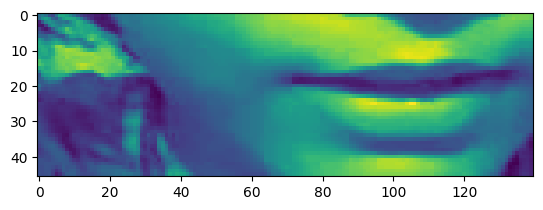

In [174]:
plt.imshow(frames[0])

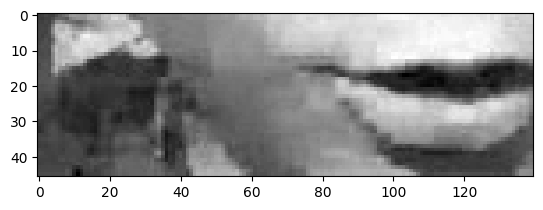

In [175]:
if len(frames) > 40:
    plt.imshow(tf.squeeze(frames[40]), cmap='gray')
    plt.show()
else:
    print("Frame index out of bounds.")

In [176]:
alignments

<tf.Tensor: shape=(12,), dtype=int64, numpy=array([ 8,  9, 39,  8,  5, 12, 12, 15, 39,  2, 25,  5], dtype=int64)>

In [177]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]) 

<tf.Tensor: shape=(), dtype=string, numpy=b'hi hello bye'>

In [178]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Create Pipeline

In [179]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes = ([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(450)
test = data.skip(450)

In [180]:
for batch in train.take(1):
    x_batch, y_batch = batch
    print("Shape of x_batch:", x_batch.shape)
    print("Shape of y_batch:", y_batch.shape)


Shape of x_batch: (2, 75, 46, 140, 1)
Shape of y_batch: (2, 40)


In [181]:
len(test)

51

In [182]:
frames, alignments = data.as_numpy_iterator().next()

In [183]:
len(frames)

2

In [184]:
alignments

array([[ 2,  9, 14, 39, 18,  5,  4, 39,  9, 14, 39,  6, 39, 19,  9, 24,
        39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39, 23,  8,  9, 20,  5, 39,  2, 25, 39, 15, 39,  5,
         9,  7,  8, 20, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [185]:
sample = data.as_numpy_iterator()

In [43]:
val = sample.next()
val[0]

array([[[[[ 1.3267647 ],
          [ 1.3267647 ],
          [ 1.3267647 ],
          ...,
          [-0.9213644 ],
          [-0.40540034],
          [-0.25798205]],

         [[ 1.3267647 ],
          [ 1.3267647 ],
          [ 1.3267647 ],
          ...,
          [-1.216201  ],
          [-0.8108007 ],
          [-0.8108007 ]],

         [[ 1.2530556 ],
          [ 1.2530556 ],
          [ 1.2530556 ],
          ...,
          [-0.4791095 ],
          [-0.33169118],
          [-0.33169118]],

         ...,

         [[ 0.958219  ],
          [ 0.958219  ],
          [ 0.958219  ],
          ...,
          [-0.11056373],
          [-0.1474183 ],
          [-0.1474183 ]],

         [[ 0.9213644 ],
          [ 0.9213644 ],
          [ 0.9213644 ],
          ...,
          [-0.22112745],
          [-0.22112745],
          [-0.22112745]],

         [[ 0.9213644 ],
          [ 0.9213644 ],
          [ 0.9213644 ],
          ...,
          [-0.22112745],
          [-0.22112745],
          

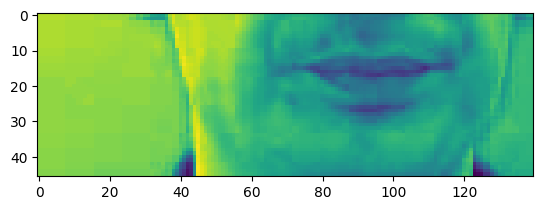

In [47]:
##videos,videos out of batch, return first frame in the video
plt.imshow(val[0][0][0])

In [48]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set white with c seven again'>

# Design Deep Neural Network

In [186]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape,Lambda, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.initializers import Orthogonal 

In [187]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [188]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

model.add(Conv3D(256, 3, padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

model.add(Conv3D(75, 3, padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences = True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences = True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+ 1, kernel_initializer='he_normal', activation='softmax'))


In [189]:
46*140*75

483000

In [190]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

In [54]:
yhat = model.predict(val[0])

1/1 [==============================] - 6s 6s/step


In [191]:
#model before train
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'se   reen  in   i  ivee   aaggainnnnnn'>

In [192]:
model.input_shape

(None, 75, 46, 140, 1)

In [193]:
model.output_shape

(None, 75, 41)

# Setup Training Options and Train

In [194]:
def scheduler(epochs, lr):
    if epochs < 30:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

In [195]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = tf.expand_dims(input_length * tf.ones(shape=(batch_len,), dtype='int64'), axis=-1)
    label_length = tf.expand_dims(label_length * tf.ones(shape=(batch_len,), dtype='int64'), axis=-1)

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [196]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False )[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [197]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = CTCLoss)

In [198]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'),monitor = 'loss', save_weights_only = True)

In [199]:
schedule_callback = LearningRateScheduler(scheduler)

In [200]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# Make a Prediction

In [85]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=13e52354-18e4-40d5-aa6d-1edb535fc286
To: c:\Users\crkpn\Documents\Programs-2\LipReading\checkpoints.zip
100%|██████████| 94.5M/94.5M [00:15<00:00, 6.17MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [201]:
model.load_weights('./models/checkpoint')

In [202]:
test_data = test.as_numpy_iterator()


In [ ]:
sample = test_data.next()

In [89]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 578ms/step


In [90]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [75]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set re it i ix ain'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'se ree in v ive again'>]

In [77]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set red with i two now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin white with h three soon'>]

# Test On a Video

In [233]:
sample = load_data(tf.convert_to_tensor('vid1.mpg'))

In [220]:
sample = load_data(tf.convert_to_tensor('vid1.mpg'))
print("Number of frames loaded:", len(sample[0]))


Number of frames loaded: 104


In [226]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [227]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [212]:
sample

(<tf.Tensor: shape=(104, 46, 140, 1), dtype=float32, numpy=
 array([[[[-0.28944165],
          [ 0.        ],
          [-0.20260915],
          ...,
          [ 1.6208732 ],
          [ 1.5919291 ],
          [ 1.562985  ]],
 
         [[-0.3183858 ],
          [ 0.3183858 ],
          [ 0.6078275 ],
          ...,
          [ 1.5919291 ],
          [ 1.5919291 ],
          [ 1.5340407 ]],
 
         [[-1.418264  ],
          [-0.69465995],
          [ 0.11577666],
          ...,
          [ 1.3893199 ],
          [ 1.3893199 ],
          [ 1.3603758 ]],
 
         ...,
 
         [[-0.8393808 ],
          [-0.8393808 ],
          [-0.7525483 ],
          ...,
          [-1.3603758 ],
          [-1.3314316 ],
          [-1.4472083 ]],
 
         [[-0.8393808 ],
          [-0.8393808 ],
          [-0.7814925 ],
          ...,
          [-1.3024874 ],
          [-1.3314316 ],
          [-1.418264  ]],
 
         [[-0.8104366 ],
          [-0.8393808 ],
          [-0.8104366 ],
         

In [222]:
print(sample[0].shape)
print(sample[1].shape)

(104, 46, 140, 1)
(12,)


In [228]:
print(sample[0].shape)
print(sample[1].shape)

(75, 46, 140, 1)
(23,)


In [214]:
sample[0].shape

TensorShape([104, 46, 140, 1])

In [223]:
trimmed_frames = sample[0][:75]
yhat = model.predict(tf.expand_dims(trimmed_frames, axis=0))


1/1 [==============================] - 0s 452ms/step


In [234]:
trimmed_frames = sample[0][:75]
yhat = model.predict(tf.expand_dims(trimmed_frames, axis=0))


1/1 [==============================] - 0s 453ms/step


In [235]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [231]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'se reen in i ive again'>]

print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [236]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'se blue st u sere slase'>]

In [237]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'hi hello bye'>]